In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tarfile   
import numpy as np
import pyprind
import pandas as pd
import os

# 資料載入、預處理

In [14]:
#with tarfile.open('aclImdb_v1.tar.gz','r:gz') as tar:
#    tar.extractall()

In [15]:
#basepath = 'aclImdb'
#
#labels = {'pos':1,'neg':0}
#bar = pyprind.ProgBar(50000)   #檔案數目
#df = pd.DataFrame()
#for s in ('test','train'):
#    for l in ('pos','neg'):
#        path = os.path.join(basepath,s,l)
#        for file  in os.listdir(path):
#            with open(os.path.join(path,file),'r',encoding= 'utf-8') as infile:  #讀取每個文件內容
#                txt = infile.read()
#            df = df.append([[txt,labels[l]]],                 #內容、標籤
#                           ignore_index = True)
#            bar.update()
#df.columns = ['review','sentiment']
#
#df.columns = ['review','sentiment']
#df.to_csv('movie_data.csv',index = False, encoding = 'utf-8') #存為csv
#df.head(10)

In [16]:
df = pd.read_csv('movie_data.csv',encoding='utf-8')   #(50000, 2)
df = df.reindex(np.random.permutation(df.index)) #隨機排列 讀取資料
target = df.pop('sentiment')
ds_raw = tf.data.Dataset.from_tensor_slices((df.values,target.values))
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][0:50],ex[1])

b'An actor asks, "What\'s my motivation?," to underst' 0
b"Robot Jox doesn't suffer from story or bad effects" 1
b"I was looking forward to Dante's contribution to t" 0


In [17]:
ds_raw = ds_raw.shuffle(50000,reshuffle_each_iteration=False)
ds_raw_test = ds_raw.take(25000)                    #前25000筆為測試集
ds_raw_train_valid = ds_raw.skip(25000)             #後25000為資料驗證
ds_raw_train = ds_raw_train_valid.take(20000)       #20000筆為訓練
ds_raw_valid = ds_raw_train_valid.skip(20000)       #5000為驗證

In [18]:
from collections import Counter

tokenizer =  tfds.deprecated.text.Tokenizer()   #tokenizer = tfds.features.text.Tokenizer() 已停用
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('vacab:',len(token_counts))

encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)
text1 = 'i love python!'

print(encoder.encode(text1))    #無python單字，自動新增為最後一個索引


vacab: 87425
[578, 1094, 30196]


In [6]:
#define_1  輸入張量

#define_2 使用tf.py_function 包裝 define_1 使用map()

def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

def encode_map(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [20]:
ds_train = ds_raw_train.map(encode_map)
ds_valid = ds_raw_valid.map(encode_map)
ds_test = ds_raw_test.map(encode_map)


train_data = ds_train.padded_batch(           #批次次分為大小32     
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))

In [21]:
#for ex in train_data.take(10):
#    print(ex[0].shape)

In [ ]:
len(token_counts)

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense

# RNN情緒分析

In [23]:
#embedding_dim = 20
#vocab_size = len(token_counts) + 2
#
#tf.random.set_seed(1)
#
### 建立模組
#bi_lstm_model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(
#        input_dim=vocab_size,
#        output_dim=embedding_dim,
#        name='embed-layer'),
#    
#    tf.keras.layers.Bidirectional(
#        tf.keras.layers.LSTM(64, name='lstm-layer'),
#        name='bidir-lstm'), 
#
#    tf.keras.layers.Dense(64, activation='relu'),
#    
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])
#
#bi_lstm_model.summary()
#
### 編譯
#bi_lstm_model.compile(
#    optimizer=tf.keras.optimizers.Adam(1e-3),
#    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#    metrics=['accuracy'])
#
#history = bi_lstm_model.fit(
#    train_data, 
#    validation_data=valid_data, 
#    epochs=10)
#
### 評估測試資料
#test_results= bi_lstm_model.evaluate(test_data)
#print('Test Acc.: {:.2f}%'.format(test_results[1]*100))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed-layer (Embedding)     (None, None, 20)          1748540   
                                                                 
 bidir-lstm (Bidirectional)  (None, 128)               43520     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,800,381
Trainable params: 1,800,381
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 195s 309ms/step - loss: 0.5402 - accuracy: 0.7210 - val_loss: 0.4975 - val_accuracy: 0.7582
Epoch 2/10
625/625 [==========

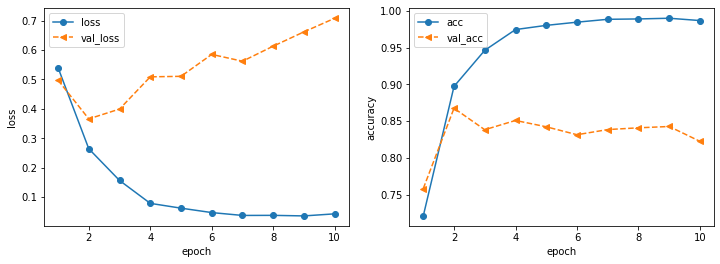

In [37]:
import matplotlib.pyplot as plt
hist = history.history

x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'-o',label = 'loss')
ax.plot(x_arr,hist['val_loss'],'--<',label = 'val_loss')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['accuracy'],'-o',label = 'acc')
ax.plot(x_arr,hist['val_accuracy'],'--<',label = 'val_acc')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
plt.show()


# 分析 loss 和 val_loss (test_loss)變化情况
https://blog.csdn.net/JaysonRen/article/details/103273519

In [1]:
#model_rnn.save('model_rnn.h5')
from tensorflow.keras.models import load_model

model_rnn = load_model('model_rnn.h5')